DEBUG:cmdstanpy:input tempfile: /tmp/tmpyjt4vi8v/hp_r704t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyjt4vi8v/ege_hnfg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30277', 'data', 'file=/tmp/tmpyjt4vi8v/hp_r704t.json', 'init=/tmp/tmpyjt4vi8v/ege_hnfg.json', 'output', 'file=/tmp/tmpyjt4vi8v/prophet_modela0jjntf9/prophet_model-20250722153230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:32:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:32:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 1287.35
RMSE: 2011.01
Forecast saved to forecast_output.csv


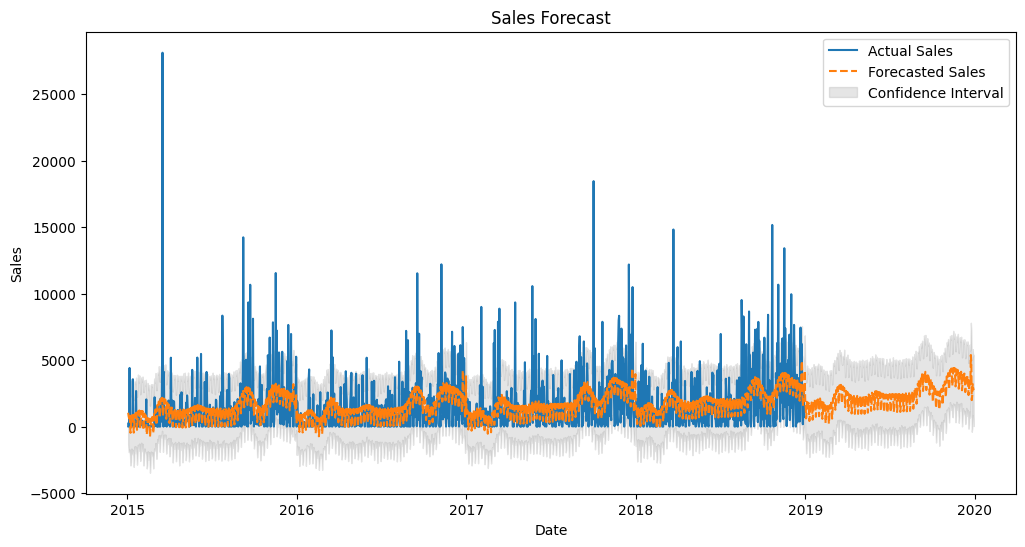

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# File path for the dataset
FILE_PATH = 'train.csv'

# Load and preprocess the Superstore dataset
def load_and_preprocess_data(file_path):
    # Read the dataset
    df = pd.read_csv(file_path)

    # Convert Order Date to datetime
    df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')

    # Aggregate sales by date (daily sales)
    df_daily = df.groupby('Order Date')['Sales'].sum().reset_index()

    # Ensure no missing dates by creating a full date range
    date_range = pd.date_range(start=df_daily['Order Date'].min(),
                             end=df_daily['Order Date'].max(), freq='D')
    df_daily = df_daily.set_index('Order Date').reindex(date_range, fill_value=0).reset_index()
    df_daily.columns = ['ds', 'y']  # Prophet requires 'ds' (date) and 'y' (value)

    # Feature engineering
    df_daily['month'] = df_daily['ds'].dt.month
    df_daily['year'] = df_daily['ds'].dt.year
    df_daily['day_of_week'] = df_daily['ds'].dt.dayofweek
    df_daily['is_holiday'] = df_daily['ds'].apply(
        lambda x: 1 if x.month == 12 and x.day in [24, 25, 31] else 0)  # Example holiday flag

    return df_daily

# Train Prophet model
def train_prophet_model(df, forecast_periods=365):
    # Initialize and fit the model
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    model.add_regressor('month')
    model.add_regressor('day_of_week')
    model.add_regressor('is_holiday')

    # Fit the model
    model.fit(df[['ds', 'y', 'month', 'day_of_week', 'is_holiday']])

    # Create future dataframe
    future = model.make_future_dataframe(periods=forecast_periods)
    future['month'] = future['ds'].dt.month
    future['day_of_week'] = future['ds'].dt.dayofweek
    future['is_holiday'] = future['ds'].apply(
        lambda x: 1 if x.month == 12 and x.day in [24, 25, 31] else 0)

    # Predict
    forecast = model.predict(future)

    return model, forecast

# Evaluate model
def evaluate_model(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")

# Save forecast for Power BI
def save_for_powerbi(forecast, df, output_path='forecast_output.csv'):
    # Merge actual and predicted data
    result = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(
        df[['ds', 'y']], on='ds', how='left')
    result.to_csv(output_path, index=False)
    print(f"Forecast saved to {output_path}")

# Main execution
if __name__ == "__main__":
    # Load data
    df = load_and_preprocess_data(FILE_PATH)

    # Train model and forecast
    model, forecast = train_prophet_model(df)

    # Evaluate model (using historical data)
    actual = df['y']
    predicted = forecast.loc[forecast['ds'].isin(df['ds']), 'yhat']
    evaluate_model(actual, predicted)

    # Save forecast for Power BI
    save_for_powerbi(forecast, df)

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(df['ds'], df['y'], label='Actual Sales')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Sales', linestyle='--')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                     color='gray', alpha=0.2, label='Confidence Interval')
    plt.legend()
    plt.title('Sales Forecast')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()


In [ ]:
pip install pandas prophet matplotlib scikit-learn